In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

import tqdm

In [2]:
def display_images(imgs):
  '''
  Display a batch of images (typically synthetic/generated images)
  '''
  r = 1
  c = imgs.shape[0]
  fig, axs = plt.subplots(r, c)
  for j in range(c):
    # black and white images
    axs[j].imshow(imgs[j, 0,:,:].detach().cpu().numpy(), cmap='gray')
    axs[j].axis('off')
  plt.show()

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim, multiplier=2):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.multiplier = multiplier
        self.fc1 = nn.Linear(input_dim, 400)
        self.fc2 = nn.Linear(400, latent_dim * multiplier)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        if self.multiplier == 1:
            x = x.view(batch_size, self.latent_dim)
        else:
          x = x.view(batch_size, self.latent_dim, self.multiplier)
        return x

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.output_dim = output_dim
        self.fc1 = nn.Linear(latent_dim, 400)
        self.fc2 = nn.Linear(400, output_dim)

    def forward(self, z):
        batch_size = z.size(0)
        z = torch.relu(self.fc1(z))
        z = self.fc2(z)
        z = z.view(batch_size, 1, 28, 28)
        return torch.sigmoid(z)

class MetricNN(nn.Module):
    def __init__(self, input_dim, latent_dim, mode='diag'):
        super(MetricNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 400)
        self.mode = mode
        if mode == 'diag':
            self.fc2 = nn.Linear(400, latent_dim)
        elif mode == 'lower':
            self.fc2 = nn.Linear(400, latent_dim * (latent_dim - 1) // 2)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [4]:
def G_inverse(z, L, c, T, lambd):
    s = 0
    N = L.shape[1]
    d = z.shape[1]
    for i in range(N):
        Li = L[i]
        ci = c[i]
        zi = z[i]
        s += Li@Li.T * torch.exp (- torch.sum(zi - ci)**2 / T**2 ) + lambd*torch.eye(d, device=z.device)
    return s

In [ ]:
class RHVAEModel(nn.Module):
    def __init__(self, input_dim=784, latent_dim=2, metric_mode = 'lower'):
        super(RHVAEModel, self).__init__()

        self.latent_dim = latent_dim
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)
        self.metric_nn = MetricNN(input_dim, latent_dim, mode=metric_mode)
        self.G_inv = torch.eye(latent_dim)
        self.G = torch.eye(latent_dim)
        self.T_metric = 0.8
        self.lambd_metric = 1e-3

    def reparameterize(self, mean, logvar, mode='sample'):
        """
        Samples from a normal distribution using the reparameterization trick.

        Parameters
        ----------
        mean : torch.Tensor
            Mean of the normal distribution. Shape (batch_size, latent_dim)

        logvar : torch.Tensor
            Diagonal log variance of the normal distribution. Shape (batch_size,
            latent_dim)

        mode : 'sample' or 'mean'
            Returns either a sample from qzx, or just the mean of qzx. The former
            is useful at training time. The latter is useful at inference time as
            the mean is usually used for reconstruction, rather than a sample.
        """
        if mode=='sample':
            # Implements the reparametrization trick (slide 43):
            std = (0.5*logvar).exp()
            eps = torch.randn(std.size()).to(std.device)
            return mean + eps * std
        elif mode=='mean':
            return mean
        else:
            return ValueError("Unknown mode: {mode}".format(mode))

    def create_matrices(self, diags, lowers=None):
        """
        Create the Cholesky factor L of the metric tensor G from the output of
        the metric neural network.

        Parameters
        ----------
        diags : torch.Tensor
            If using diagonal metric, the diagonal coefficients predicted by
            the metric neural network. Shape (batch_size, latent_dim)

        lowers : torch.Tensor
            If using lower-triangular metric, the lower-triangular coefficients
            predicted by the metric neural network. Shape
            (batch_size, latent_dim * (latent_dim - 1) // 2)
        """
        if self.metric_nn.mode == 'diag':
            L = torch.diag_embed(torch.exp(0.5*diags))
        elif self.metric_nn.mode == 'lower':
            L = torch.zeros((diags.shape[0], self.latent_dim, self.latent_dim), device=diags.device)
            tril_indices = torch.tril_indices(row=self.latent_dim, col=self.latent_dim, offset=-1)
            L[:, tril_indices[0], tril_indices[1]] = lowers
            diag_indices = torch.arange(self.latent_dim)
            L[:, diag_indices, diag_indices] = diags
        return L

    def forward(self, x):
        """
        Forward pass of model, used for training or reconstruction.

        Parameters
        ----------
        x : torch.Tensor
            Batch of data. Shape (batch_size, n_chan, height, width)
        """

        # stats_qzx is the output of the encoder
        stats_qzx = self.encoder(x)

        # Use the reparametrization trick to sample from q(z|x)
        samples_qzx = self.reparameterize(*stats_qzx.unbind(-1), mode='sample')

        # Decode the samples to image space
        reconstructions = self.decoder(samples_qzx)

        c = stats_qzx[:,:,0]  # Mean of q(z|x)
        coefsL = self.metric_nn(x)
        L = self.create_matrices(*coefsL.unbind(-1))
        self.G_inv = G_inverse(samples_qzx, L, c, self.T_metric, self.lambd_metric)
        self.G = torch.inverse(self.G_inv)

        samples_vz = self.sample_vz(samples_qzx.shape[0])

        # Return everything:
        return {
            'reconstructions': reconstructions,
            'stats_qzx0': stats_qzx,
            'samples_qzx0': samples_qzx,
            'samples_vz0': samples_vz
        }

    def sample_qzx(self, x):
        """
        Returns a sample z from the latent distribution q(z|x).

        Parameters
        ----------
        x : torch.Tensor
            Batch of data. Shape (batch_size, n_chan, height, width)
        """
        stats_qzx = self.encoder(x)
        samples_qzx = self.reparameterize(*stats_qzx.unbind(-1))
        return samples_qzx

    def sample_vz(self, N):
        return torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(self.G.shape[0]), covariance_matrix=self.G).sample((N,))

    def sample_pz(self, N): 
        # A MODIFIER LA PRIOR
        samples_pz = torch.randn(N, self.latent_dim, device=self.decoder.fc1.weight.device)
        return samples_pz
    
    def leapfrog(self, z0, v0, epsilon, L):
        raise NotImplementedError("Leapfrog method not implemented yet.")

    def generate_samples(self, N):
        
        samples_pz = self.sample_pz(N)

        # Decode the z's to obtain samples in image space (here, probability
        # maps which can later be sampled from or thresholded)
        generations = self.decoder(samples_pz) # FILL IN CODE
        return {'generations': generations}

In [40]:
def rhvae_loss(reconstructions, data, stats_qzx, beta=0.0012):
    """
    Computes the VAE loss.

    Parameters
    ----------
    reconstructions : torch.Tensor
        Reconstructed data. Shape (batch_size, n_chan, height, width)

    data : torch.Tensor
        Original data. Shape (batch_size, n_chan, height, width)

    stats_qzx : torch.Tensor
        Statistics of the latent distribution q(z|x). Shape
        (batch_size, latent_dim * 2)
    """

    # Reconstruction loss (binary cross-entropy)
    bce_loss = nn.functional.binary_cross_entropy(
        reconstructions,
        data,
        reduction='sum'
    )

    # KL divergence between q(z|x) and p(z) (closed form for two Gaussians)
    mean, logvar = stats_qzx.unbind(-1)
    kl_div = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

    # Total loss
    total_loss = bce_loss + beta * kl_div

    return total_loss

In [ ]:
batch_size = 64

# MNIST Dataset
mnist_trainset = datasets.MNIST(root='.data/mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
mnist_testset = datasets.MNIST(root='.data/mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

#create data loader with smaller dataset size
max_mnist_size = 5000
mnist_trainset_reduced = torch.utils.data.random_split(mnist_trainset, [max_mnist_size, len(mnist_trainset)-max_mnist_size])[0]
mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True, drop_last=False)

# download test dataset
max_mnist_size = 1000
mnist_testset_reduced = torch.utils.data.random_split(mnist_testset, [max_mnist_size, len(mnist_testset)-max_mnist_size])[0]
mnist_test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=batch_size, shuffle=False, drop_last=False)


In [43]:
# Parameters
input_dim = 28 * 28
latent_dim = 2

learning_rate = 1e-3
n_epoch = 10 # if running on GPU you can use more epochs (10 or more)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Model
rhvae_model = RHVAEModel(input_dim=input_dim, latent_dim=latent_dim, metric_mode='diag')
rhvae_model = rhvae_model.to(device)

optimizer = torch.optim.AdamW(params=rhvae_model.parameters(), lr=learning_rate, weight_decay=1e-3)

cpu


In [44]:
rhvae_model.train()

for epoch in range(0,n_epoch):
  train_loss=0.0

  with tqdm.tqdm(mnist_train_loader, unit="batch") as tepoch:
    for data, labels in tepoch:
      tepoch.set_description(f"Epoch {epoch}")

      # Put data on correct device, GPU or CPU
      data = data.to(device)

      # Pass the input data through the model
      predict = rhvae_model(data)
      reconstructions = predict['reconstructions']
      stats_qzx0 = predict['stats_qzx0']
      samples_qzx0 = predict['samples_qzx0']
      samples_vz0 = predict['samples_vz0']

      # Normalizing flows
      #samples_zK, samples_vK = rhvae_model.leapfrog(samples_qzx0, samples_vz0, epsilon=0.1, L=10)

      # Compute the RHVAE loss
      loss = rhvae_loss(reconstructions, data, stats_qzx0)

      # Backpropagate
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Aggregate the training loss for display at the end of the epoch
      train_loss += loss.item()

      # tqdm bar displays the loss
      tepoch.set_postfix(loss=loss.item())

  print('Epoch {}: Train Loss: {:.4f}'.format(epoch, train_loss/len(mnist_train_loader)))

Epoch 0: 100%|██████████| 938/938 [00:05<00:00, 180.67batch/s, loss=5.18e+3]


Epoch 0: Train Loss: 11016.1782


Epoch 1: 100%|██████████| 938/938 [00:05<00:00, 180.21batch/s, loss=4.96e+3]


Epoch 1: Train Loss: 9955.0018


Epoch 2: 100%|██████████| 938/938 [00:05<00:00, 182.44batch/s, loss=5.24e+3]


Epoch 2: Train Loss: 9712.9525


Epoch 3: 100%|██████████| 938/938 [00:05<00:00, 184.20batch/s, loss=5.24e+3]


Epoch 3: Train Loss: 9562.0301


Epoch 4: 100%|██████████| 938/938 [00:05<00:00, 183.72batch/s, loss=4.38e+3]


Epoch 4: Train Loss: 9454.4064


Epoch 5: 100%|██████████| 938/938 [00:05<00:00, 186.65batch/s, loss=4.45e+3]


Epoch 5: Train Loss: 9369.0356


Epoch 6: 100%|██████████| 938/938 [00:05<00:00, 181.43batch/s, loss=4.7e+3] 


Epoch 6: Train Loss: 9306.1004


Epoch 7: 100%|██████████| 938/938 [00:05<00:00, 180.14batch/s, loss=4.26e+3]


Epoch 7: Train Loss: 9249.4194


Epoch 8: 100%|██████████| 938/938 [00:05<00:00, 180.57batch/s, loss=5.26e+3]


Epoch 8: Train Loss: 9199.3869


Epoch 9: 100%|██████████| 938/938 [00:05<00:00, 178.01batch/s, loss=4.33e+3]

Epoch 9: Train Loss: 9158.2653


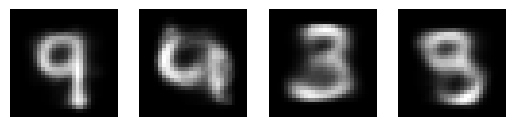

In [55]:
rhvae_model.eval()
samples = rhvae_model.generate_samples(4)['generations'].detach().cpu()
display_images(samples)